# Run Hybrid Quantum Algorithms in PennyLane as Fully Managed Jobs on Amazon Braket

In this _hello-world_ example we show how to run a hybrid quantum algorithm implemented in __PennyLane__ as a fully managed job on __Amazon Braket__. The goals of this _hello-world_ demo for hybrid workloads can tbe summarized as follows: 
- We show in detail how variational hybrid quantum algorithms can be implemented efficiently with PennyLane. 
- We show in detial how to run such a hybrid workload as a fully managed job on Amazaon Braket: Specifically, we discuss how Amazon Braket spins up classical compute, brokers the entire execution, then tears down the environment at the end of the computation. We also discuss touchpoints with other AWS services such as S3 and CloudWatch.  
- We provide an end-to-end walk-through for the user workflow and experience when setting up fully managed jobs on Amazon Braket.  

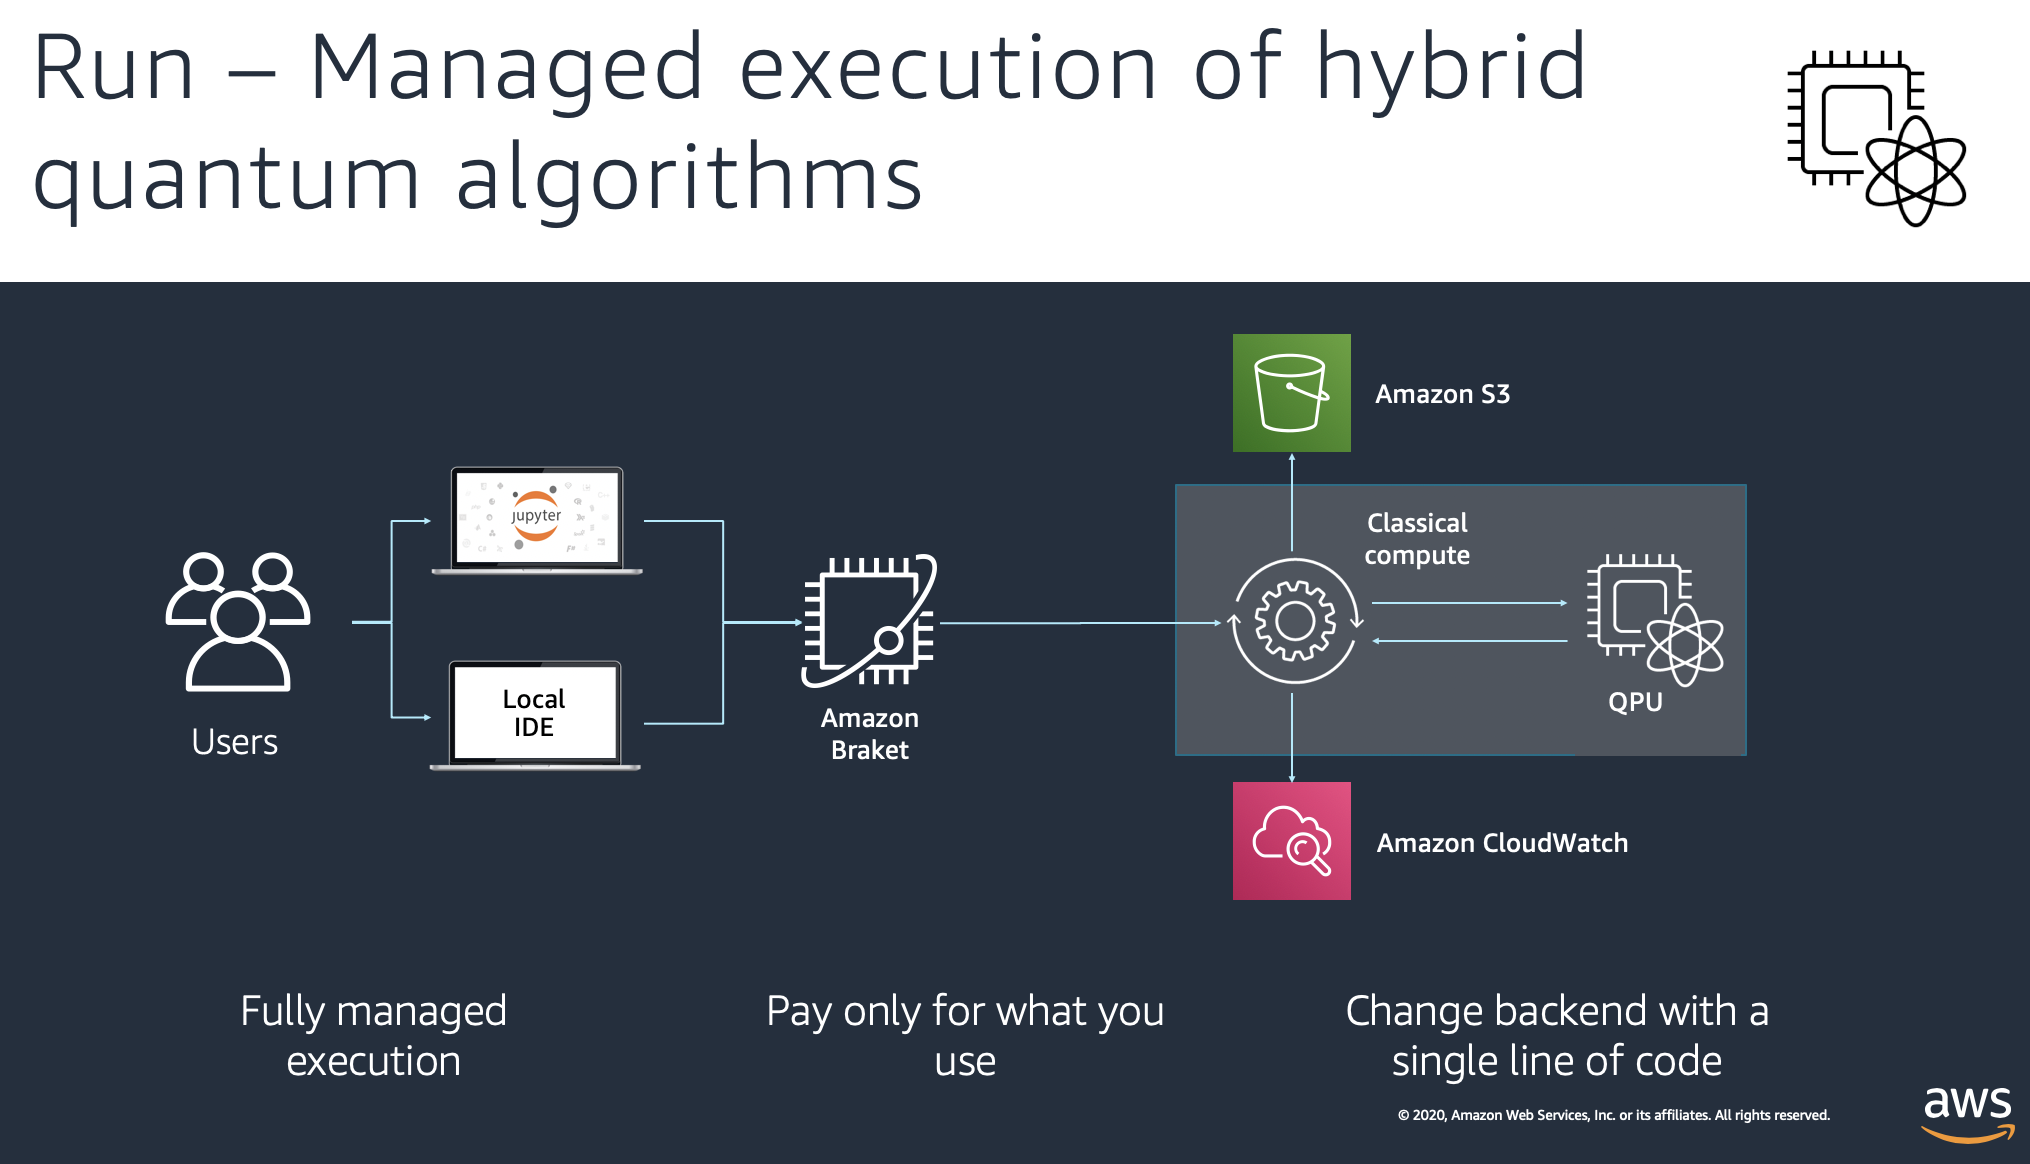

In [1]:
from IPython.display import Image
Image(filename='figures/Braket_Run_scheme.png', width=800, height=800)

__RUN MANAGED HYBRID WORKLOAD__:
- Build quantum algorithms in Jupyter Lab or a local IDE, using __PennyLane__.
- Submit the program together with hardware and backend specifications to the Braket API (simply write JSON file).
- Select EC2 instance type and configurations for classical part of computation.
- Choose from multiple state-of-the-art simulator or QC backends (for circuit execution).
- __MANAGED SERVERLESS__: Braket will spin up the classical compute and broker the execution between CPU and QPU.
- Pay only for what you use; tear down resources when done. 
- Touchpoints to other AWS services: 
    - All input and output data can be stored in Amazon Simple Storage Service (S3).
    - Logs and custom metrics reported to Amazon CloudWatch. 

## Update your config file

Before we get started, let's make some changes to the file ```config.py``` located in the same folder as this notebook. This holds basic information related to your AWS account and setup. 

1. **region**: This is the AWS Region in which the classical part of the computation will be run. To reduce latency, we recommend "us-west-1" for Rigetti and "us-east-1" for IonQ. 
2. **role**: This is the execution role that allows Amazon Braket to perform actions on your behalf. It was created as part of the setup process. You can find the ARN (this acronym stands for AWS Resource Name) in your AWS console. Open the console, navigate to IAM in the list of AWS services and click on 'Roles'. In the search field, type "AmazonBraketJobExecutionRole" and click on the role. You will find your Role ARN on the top of the page. 
3. **bucket**: This is the S3 bucket you will use for this example. You can either create a new bucket in the AWS console or use an existing one. When setting up the bucket you should choose the same region as you set up above for the classical compute.  
4. **bucket_key**: This is the 'folder' (this is technically not quite correct but let's not worry about it at this point) in which the results of individual circuit evaluations will be stored. You can add anything you like here. It will be created on the fly.

## IMPORTS and SETUP

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
from datetime import datetime
import time
import tarfile
import pickle
import os
import boto3
from braket.aws import AwsSession 

In [3]:
# import your config information  
import config

In [4]:
# setup session
region = config.region
session = boto3.Session(region_name=region)
aws_session = AwsSession(boto_session=session)

In [5]:
# setup client
braket_client = aws_session.braket_client

In [6]:
# S3 bucket
bucket = config.bucket # enter your bucket; see config file

## MANAGED JOBS ON AMAZON BRAKET

In the following we walk through the essential steps for running a managed job on Amazon Braket. These are: (0) Setup our problem, (1) upload problem to S3, (2) package code into single .py file ready for managed job. Upload script to S3 as well, (3) submit managed job with simple ```create_quantum_job()``` API call, and (4) perform postprocesing once the job has completed. For the _hello-world_ example considered here, we can skip steps (0)-(1).  

In [7]:
import logging
from botocore.exceptions import ClientError

# helper function to upload to S3
def upload_file(file_name, bucket, object_name=None):
    """
    Upload a file to an S3 bucket
    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = session.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

__STEP 2__: Package code into single .py file ready for managed job where user can define underlying hardware in API call. Upload script to S3. 

In [8]:
# local IDE: show training job script for managed job (use ‘! more’ on Windows)
! cat pl_job_demo.py

#!/usr/bin/python3

# A sample program that runs a hybrid quantum algorithm written in PennyLane as managed job on Amazon Braket

# Imports
import os
import sys
import pickle
import json
import time
import numpy as np
import pennylane as qml

# AWS imports
import boto3
from botocore.session import get_session
from braket.aws import AwsSession


########################
# CONTAINER PATH SETUP #
########################

# Braket file directory
prefix = '/opt/ml/'

# Data location
input_path = prefix + 'input/data'
param_path = os.path.join(prefix, 'input/config/hyperparameters.json')  # Passed parameters can be retrieved here
output_path = os.path.join(prefix, 'output')  # Failure output & error messages should be written here

# Model Results
model_path = os.path.join(prefix, 'model')  # All results should be written here

# This algorithm has a single channel of input data called 'training'. Since we run in
# File mode, the input files are copied to the directory specified here.
chann

__NOTE__: Changing to a QPU as backend for this hybrid algorithm amounts to simply redefining the ```qml.device()``` object in our training script *pl_job_demo.py*. 

In [9]:
# upload training script to s3
upload_file('pl_job_demo.py', bucket, 'pl_job_demo.py')

True

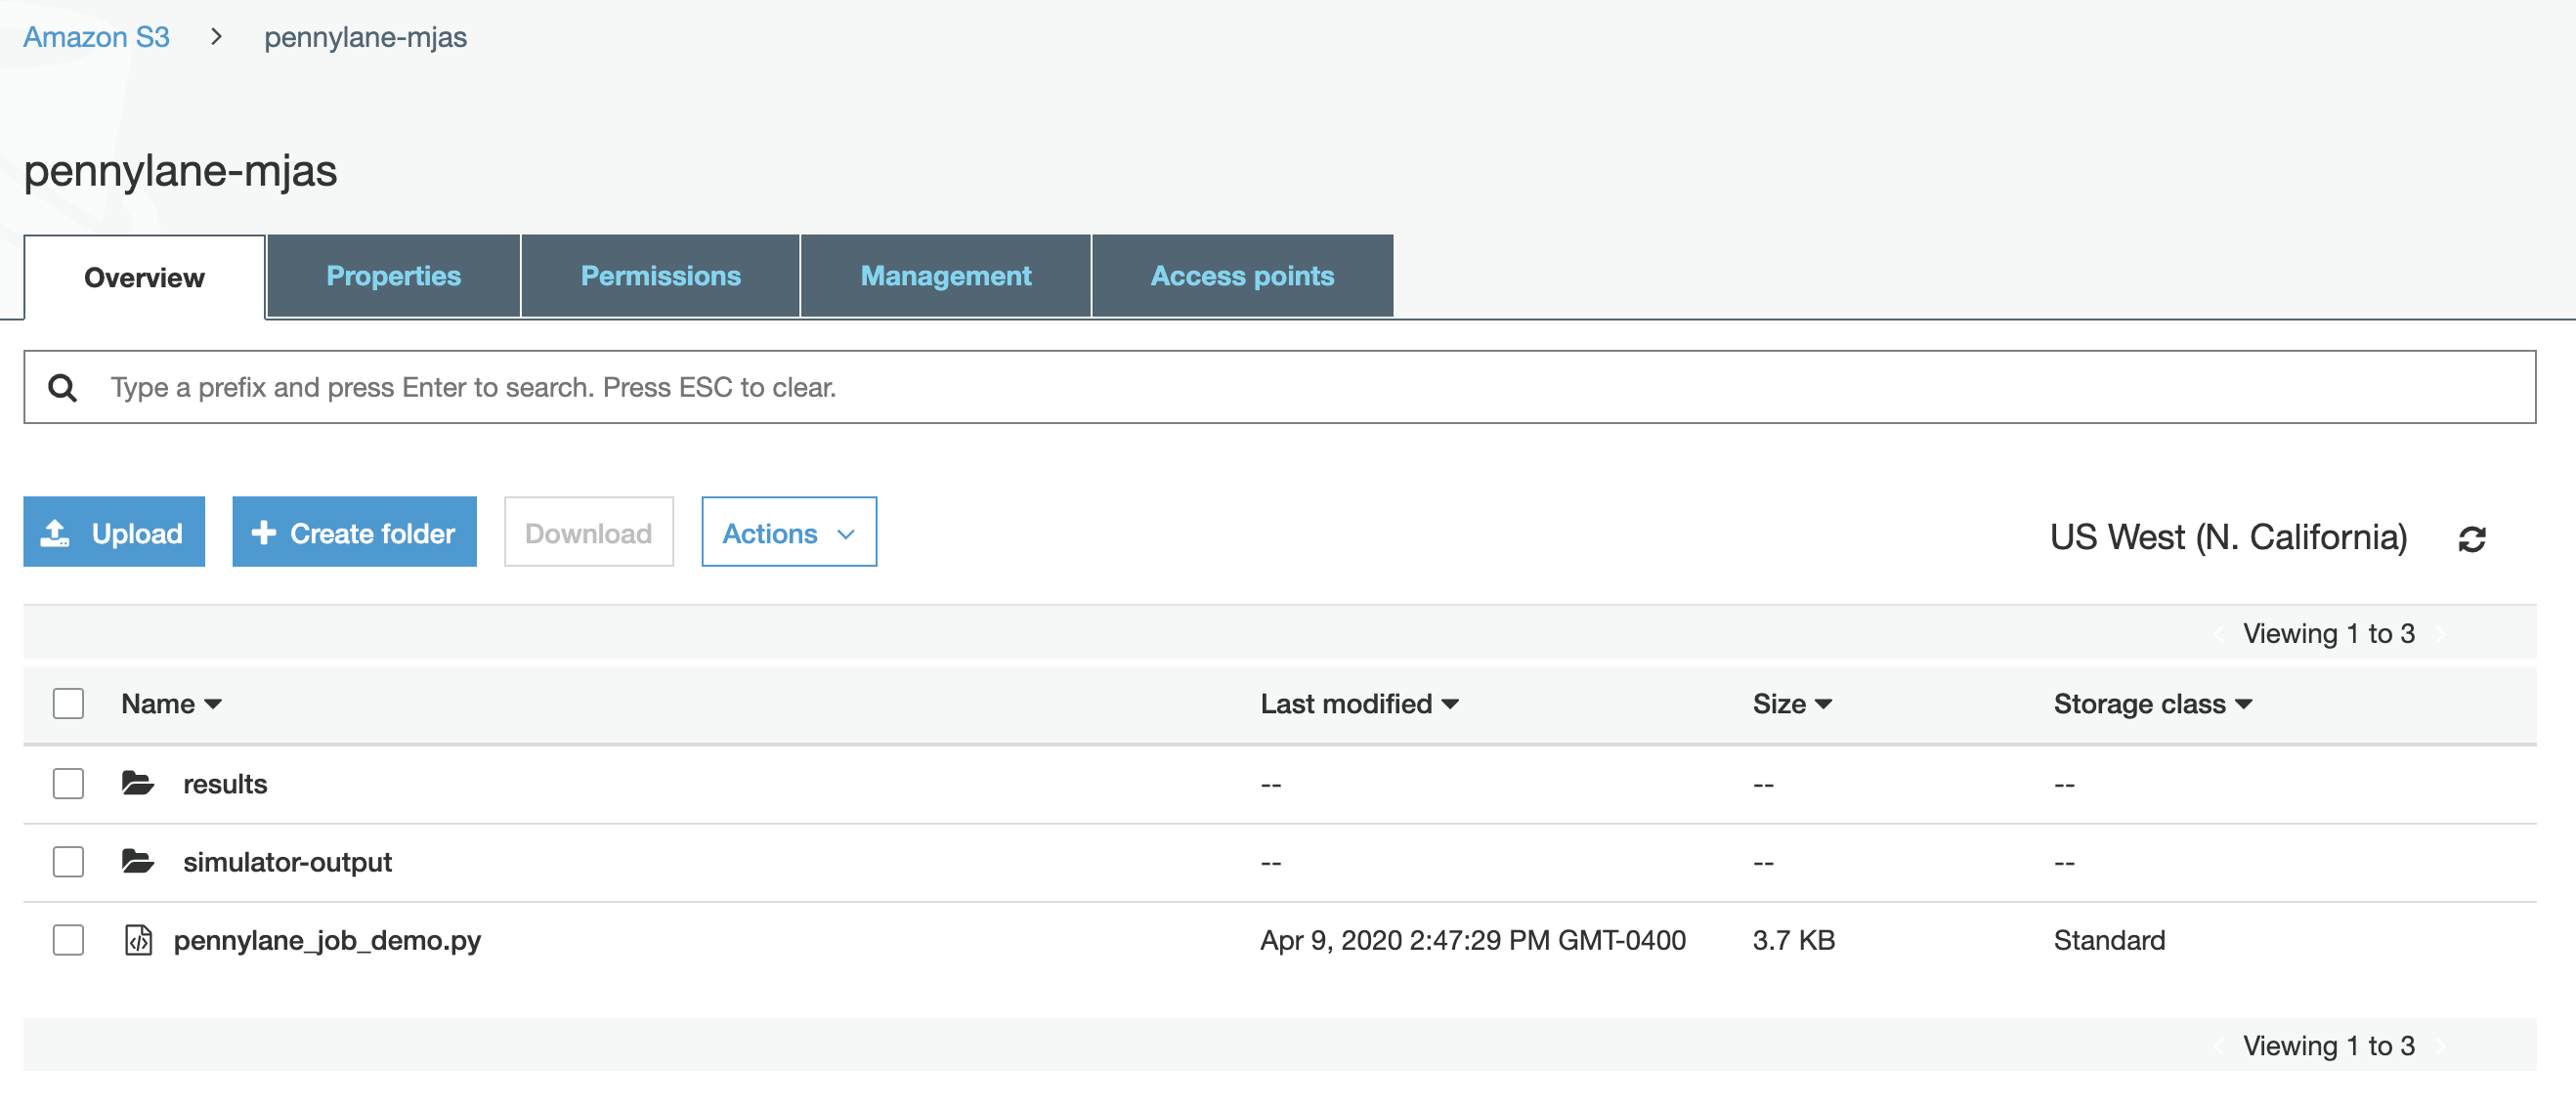

In [10]:
# screenshot from S3 location
Image(filename='figures/script_pl_s3.png', width=800, height=800)

__Step 3__: Submit managed job specifying ```hardware``` in API call and pointing to the __S3 location__ where script with instructions is located. Customer can also define ```stoppingCondition``` and custom metrics to be tracked by __CloudWatch__. Hybrid algorithms executed by Amazon Braket service as managed jobs can automatically export metrics to Amazon CloudWatch. 

To export metrics to Amazon CloudWatch: 
1.	Decide the metrics that you want to emit. This can be done while writing the hybrid algorithm.
2.	Decide the format that the generated metrics will take.
Metrics will be automatically pushed to Amazon CloudWatch. 

In [11]:
# run training job tagged with custom job name
project_name = 'pennylane-demo'
job_name = project_name+'-'+datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
print('jobName with time stamp:', job_name)

jobName with time stamp: pennylane-demo-20200604141944


In [12]:
# call API
my_role = config.role # enter your execution role here; see config file
output_path = "s3://"+bucket+"/results" # enter your output path here
hardware = "ml.m4.xlarge"               # this is the EC2 instance type that runs the classical part of the computation
my_python_script = "pl_job_demo.py"
steps = 30 # hyperparameter: number of optimization steps

quantum_job = braket_client.create_quantum_job(
    jobName=job_name,
    resourceConfig={
        "instanceCount": 1,
        "instanceType": hardware,
        "volumeSizeInGb": 50
    },
    outputDataConfig={
        "s3OutputPath": output_path           # This is where results will be stored. 
    },
    stoppingCondition={
        "maxRuntimeInSeconds": 86400
    },
    sagemakerRoleArn=my_role,
    inputScriptConfig={
        "scriptS3Bucket": bucket,
        "scriptS3ObjectKey": my_python_script  # This is where your script is stored 
    },
    metricDefinitions = [{                     # Custom metrics are defined here
        'name': "cost",
        'regex': "cost=(.*?);"
    },
    {
        'name': "expectation",
        'regex': "expectation=(.*?);"
    }],
    hyperParameters={                          # You can pass any hyperparameters into your algorithm here
        'steps': str(steps),
        'bucket': config.bucket,               # The bucket and key where your tasks are stored are required.
        'bucket_key': config.bucket_key,
        'region': config.region
        },
)

# print results location
print('Results will be stored here:', output_path)

Results will be stored here: s3://pennylane-mjas/results


In [13]:
# print quantum Job metadata with date, status code etc.
date = quantum_job['ResponseMetadata']['HTTPHeaders']['date']
print(date)

Thu, 04 Jun 2020 18:19:45 GMT


Use Braket's ```get_quantum_job``` API to programmatically check the status of your job.

In [14]:
# programmatically check the status of job
# corresponding CLI call: aws braket get-quantum-job --quantum-job-arn my_job_arn
quantum_job_arn = quantum_job['quantumJobArn']
job_info = braket_client.get_quantum_job(quantumJobArn=quantum_job_arn)
job_status = job_info['jobStatus']

In [15]:
# regularly check job status
# wait for job to complete
while job_status != 'Completed':
    job_status = braket_client.get_quantum_job(quantumJobArn=quantum_job_arn)['jobStatus']
    print('Status:', job_status)
    if job_status == 'Failed':
        print('Status:', job_status)
        break
    time.sleep(60)

Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: Completed


__NOTE__: If needed, you can also programmatically cancel a job in flight using the stop-quantum-job API; see ```aws braket stop-quantum-job help``` for details. 

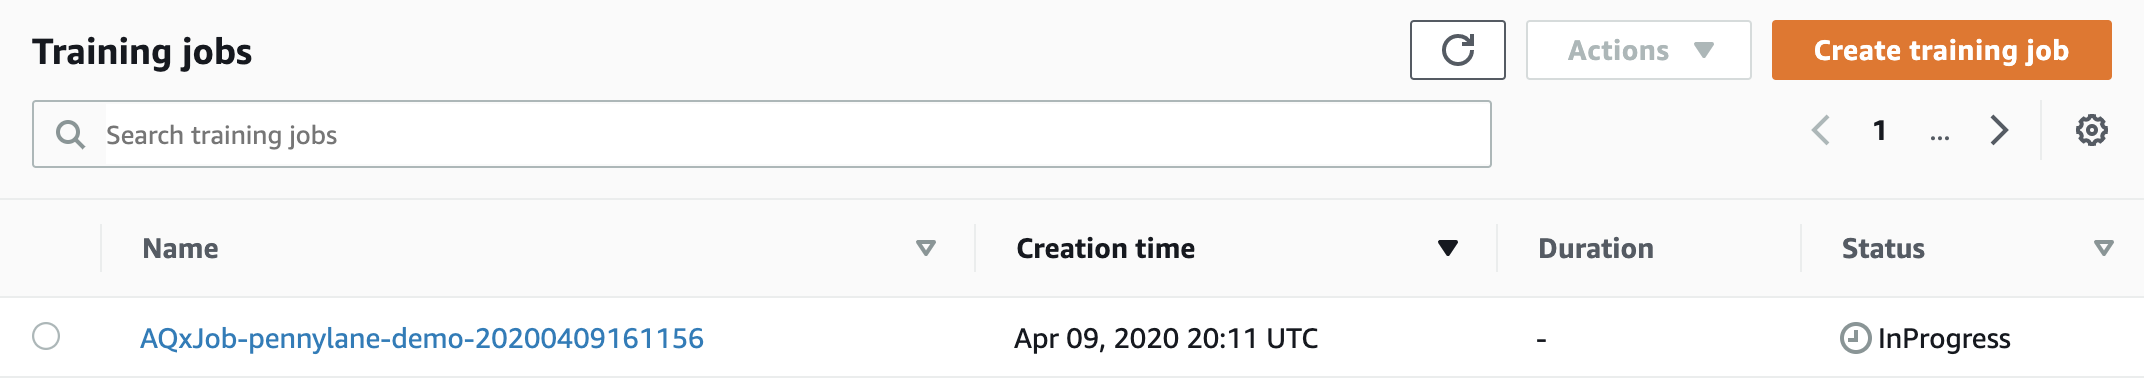

In [16]:
# screenshot from console
Image(filename='figures/pl_job_in_progress.png', width=1000, height=1000)

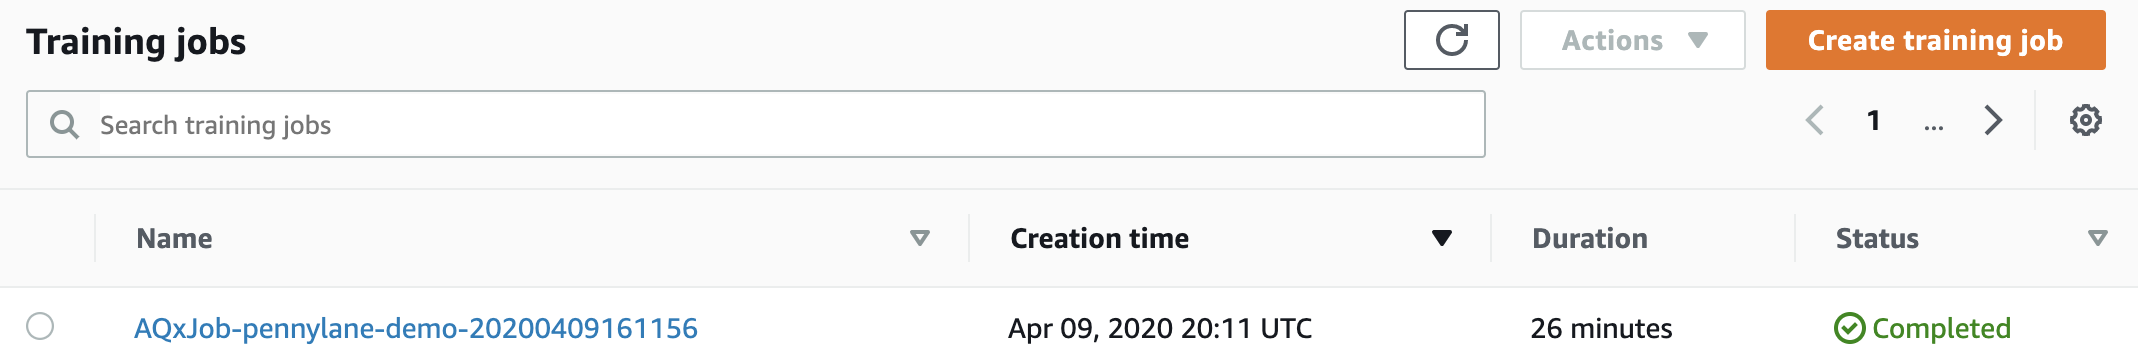

In [17]:
# screenshot from console
Image(filename='figures/pl_job_completed.png', width=1000, height=1000)

### Track Custom Metrics of Managed Job in CloudWatch

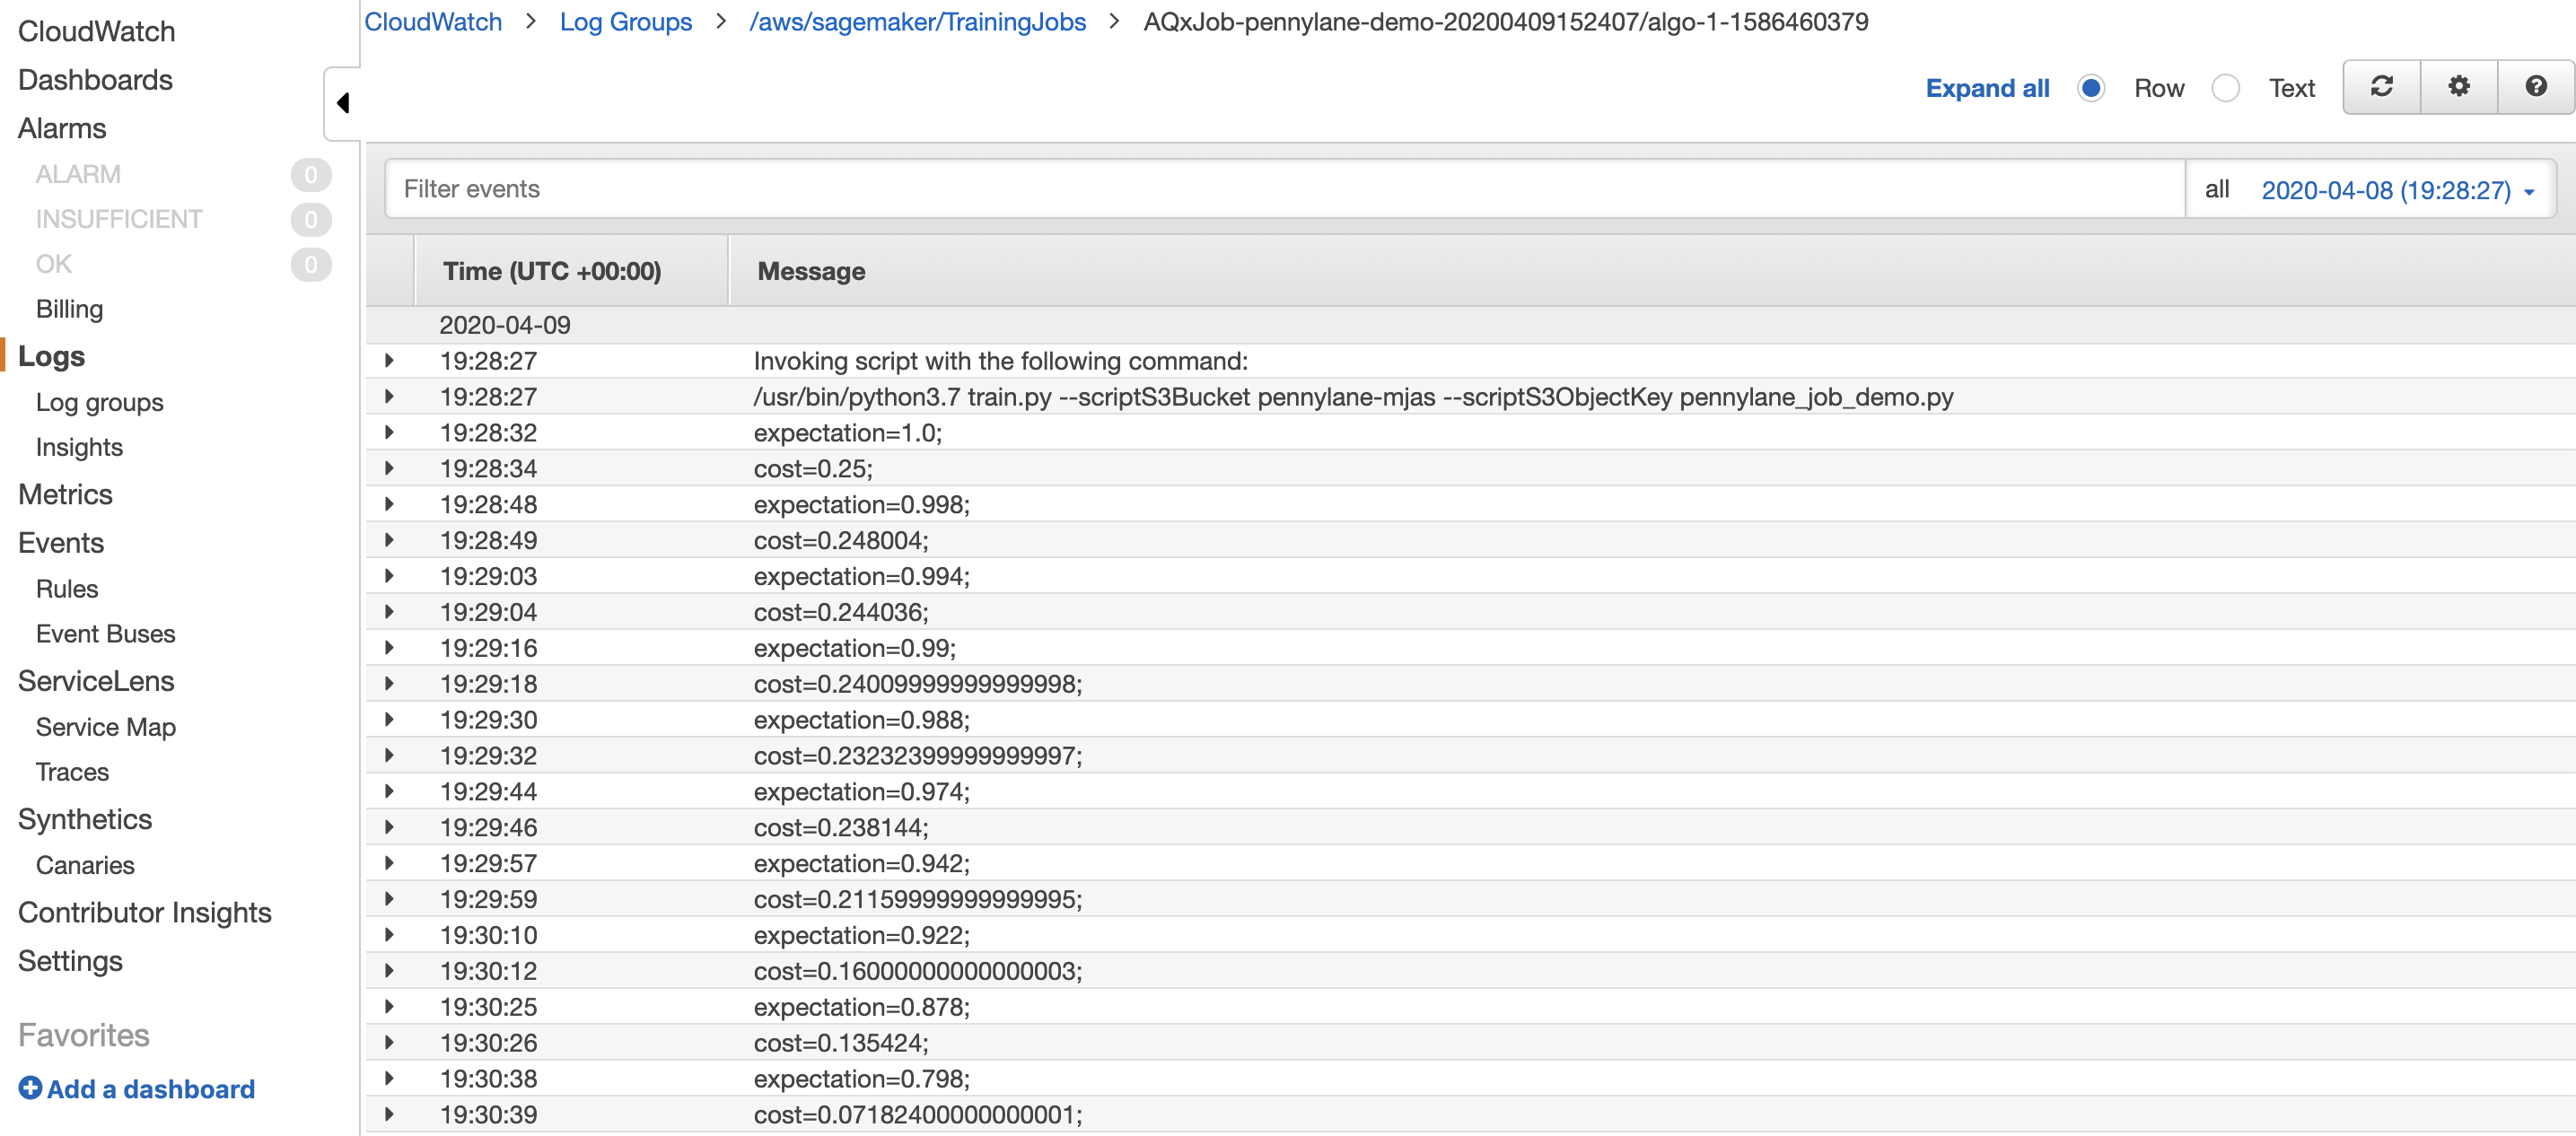

In [18]:
# visualize custome metrics in CloudWatch console
Image(filename='figures/pl_cw_logs.png', width=700, height=700)

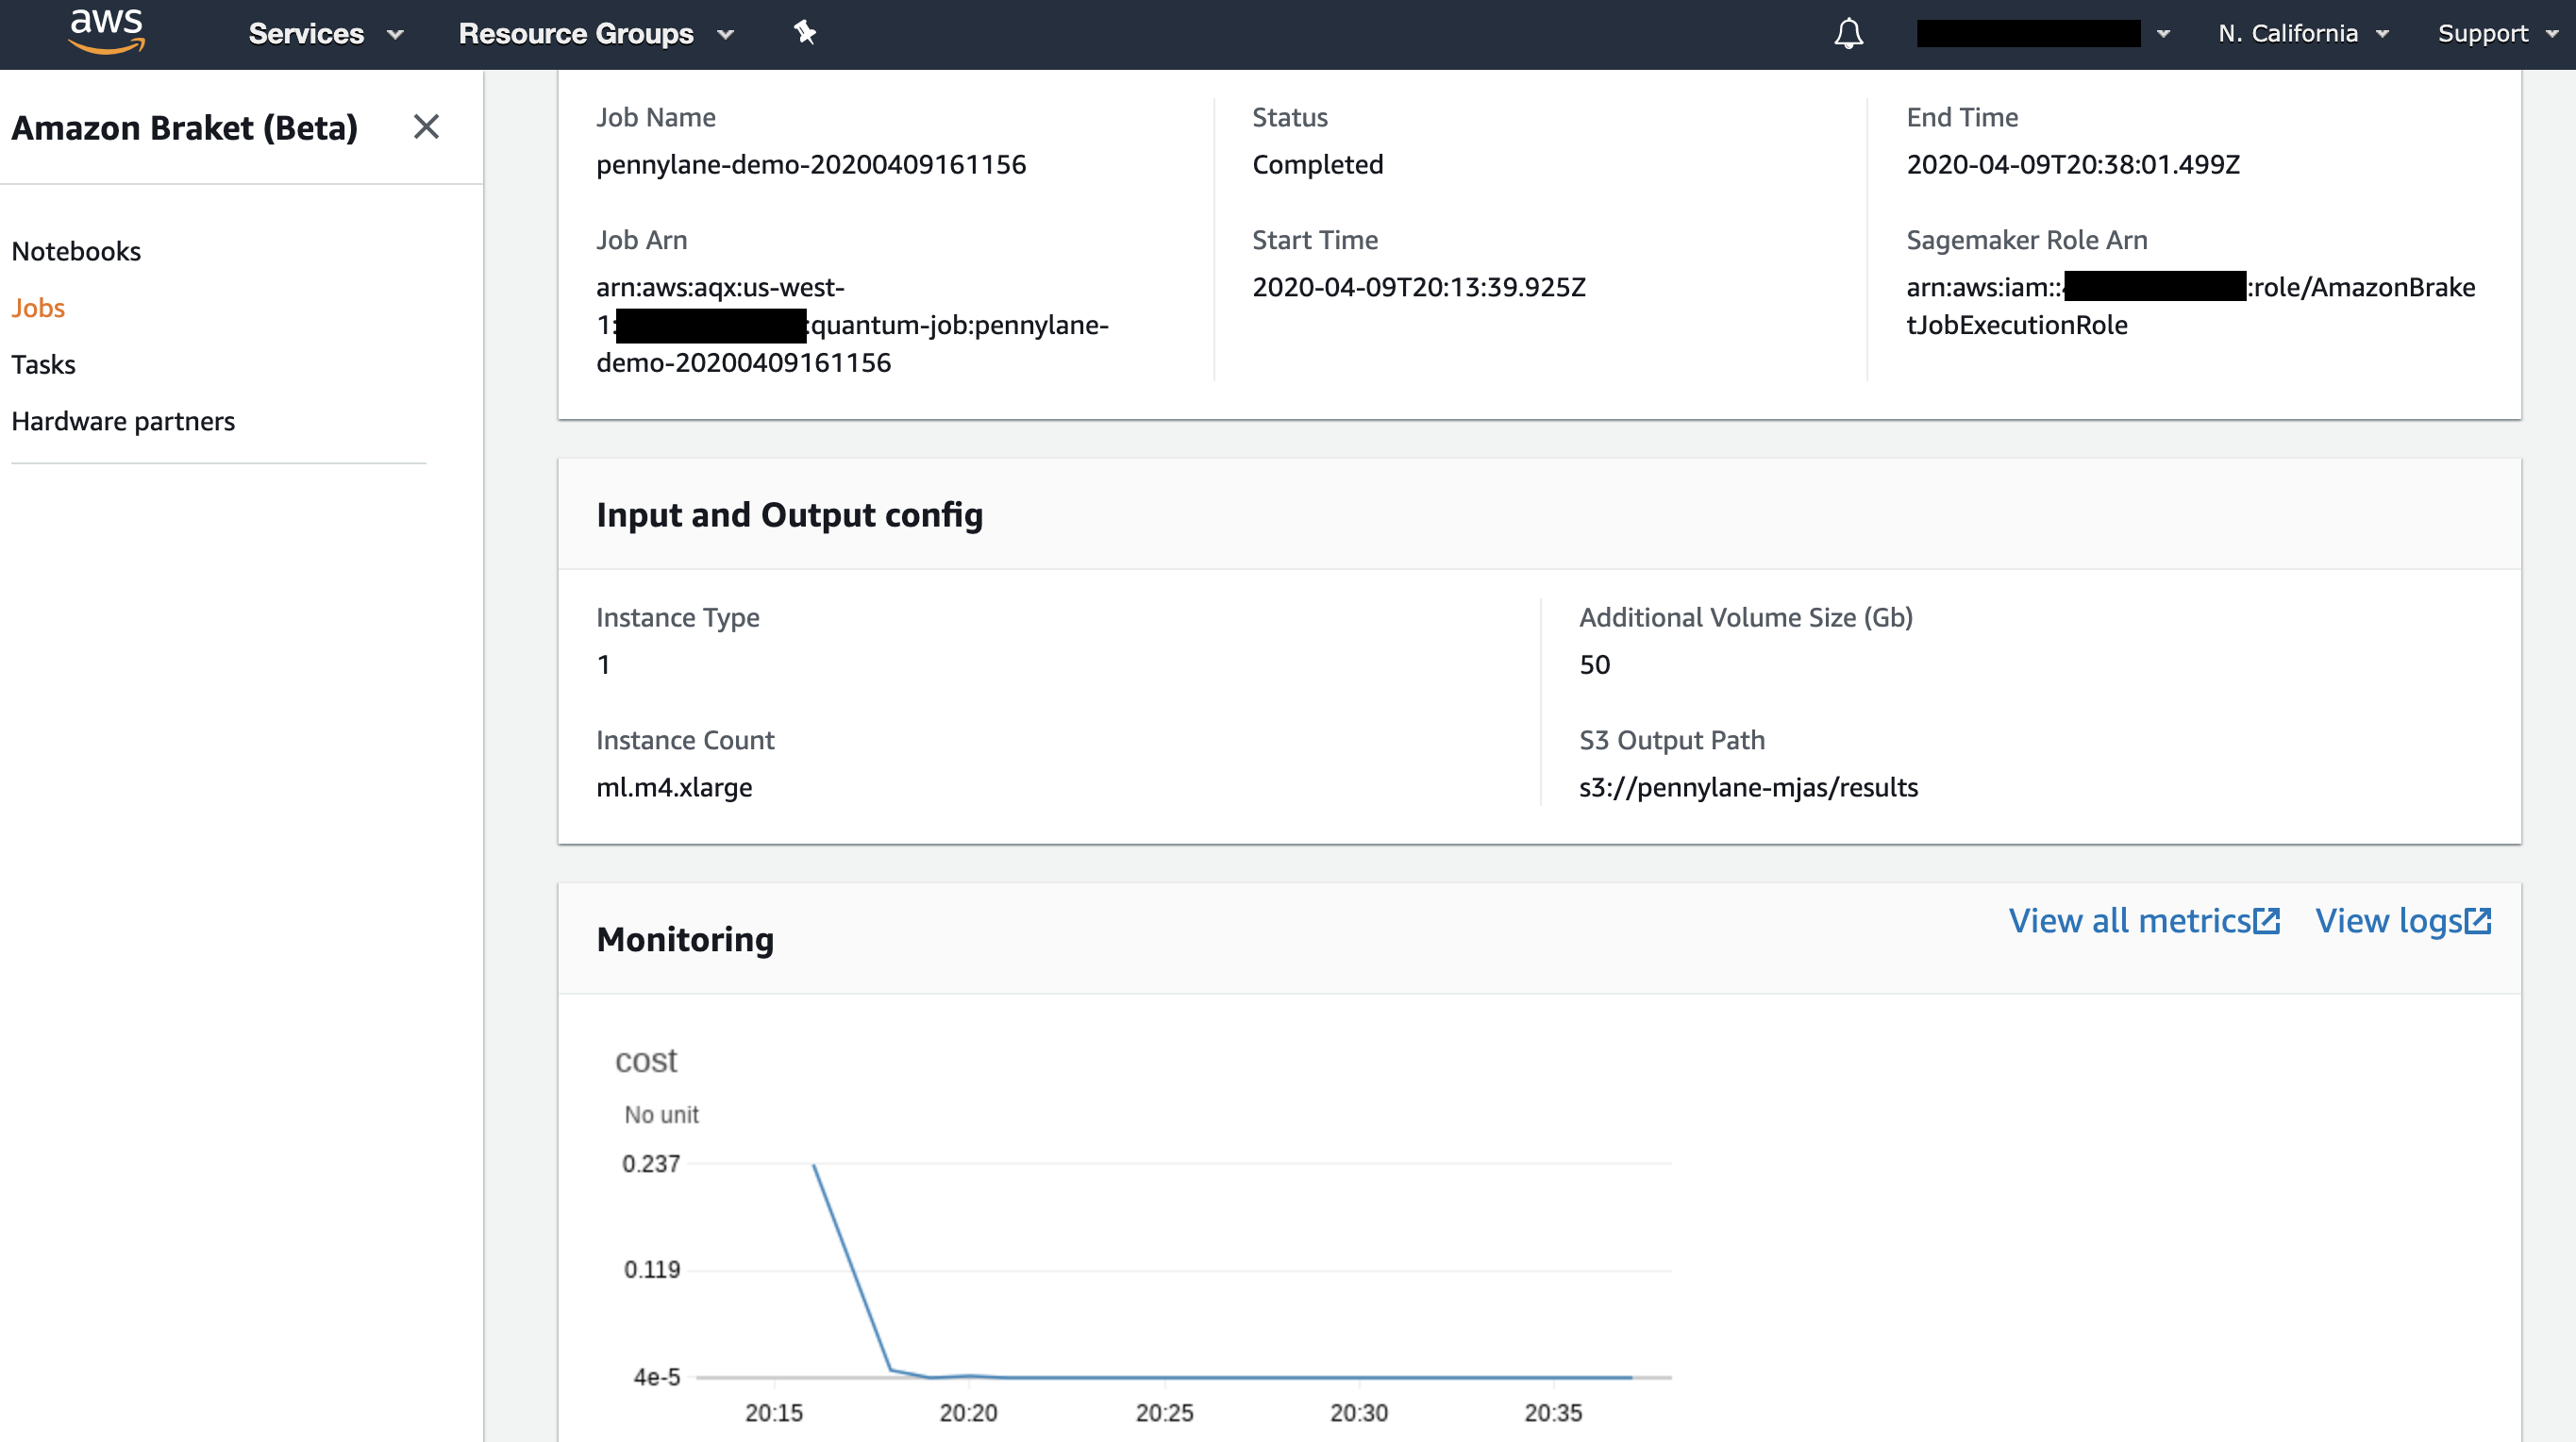

In [19]:
# CloudWatch custom metrics integrated into Braket console experience
Image(filename='figures/pl_Braket_console.png', width=800, height=800)

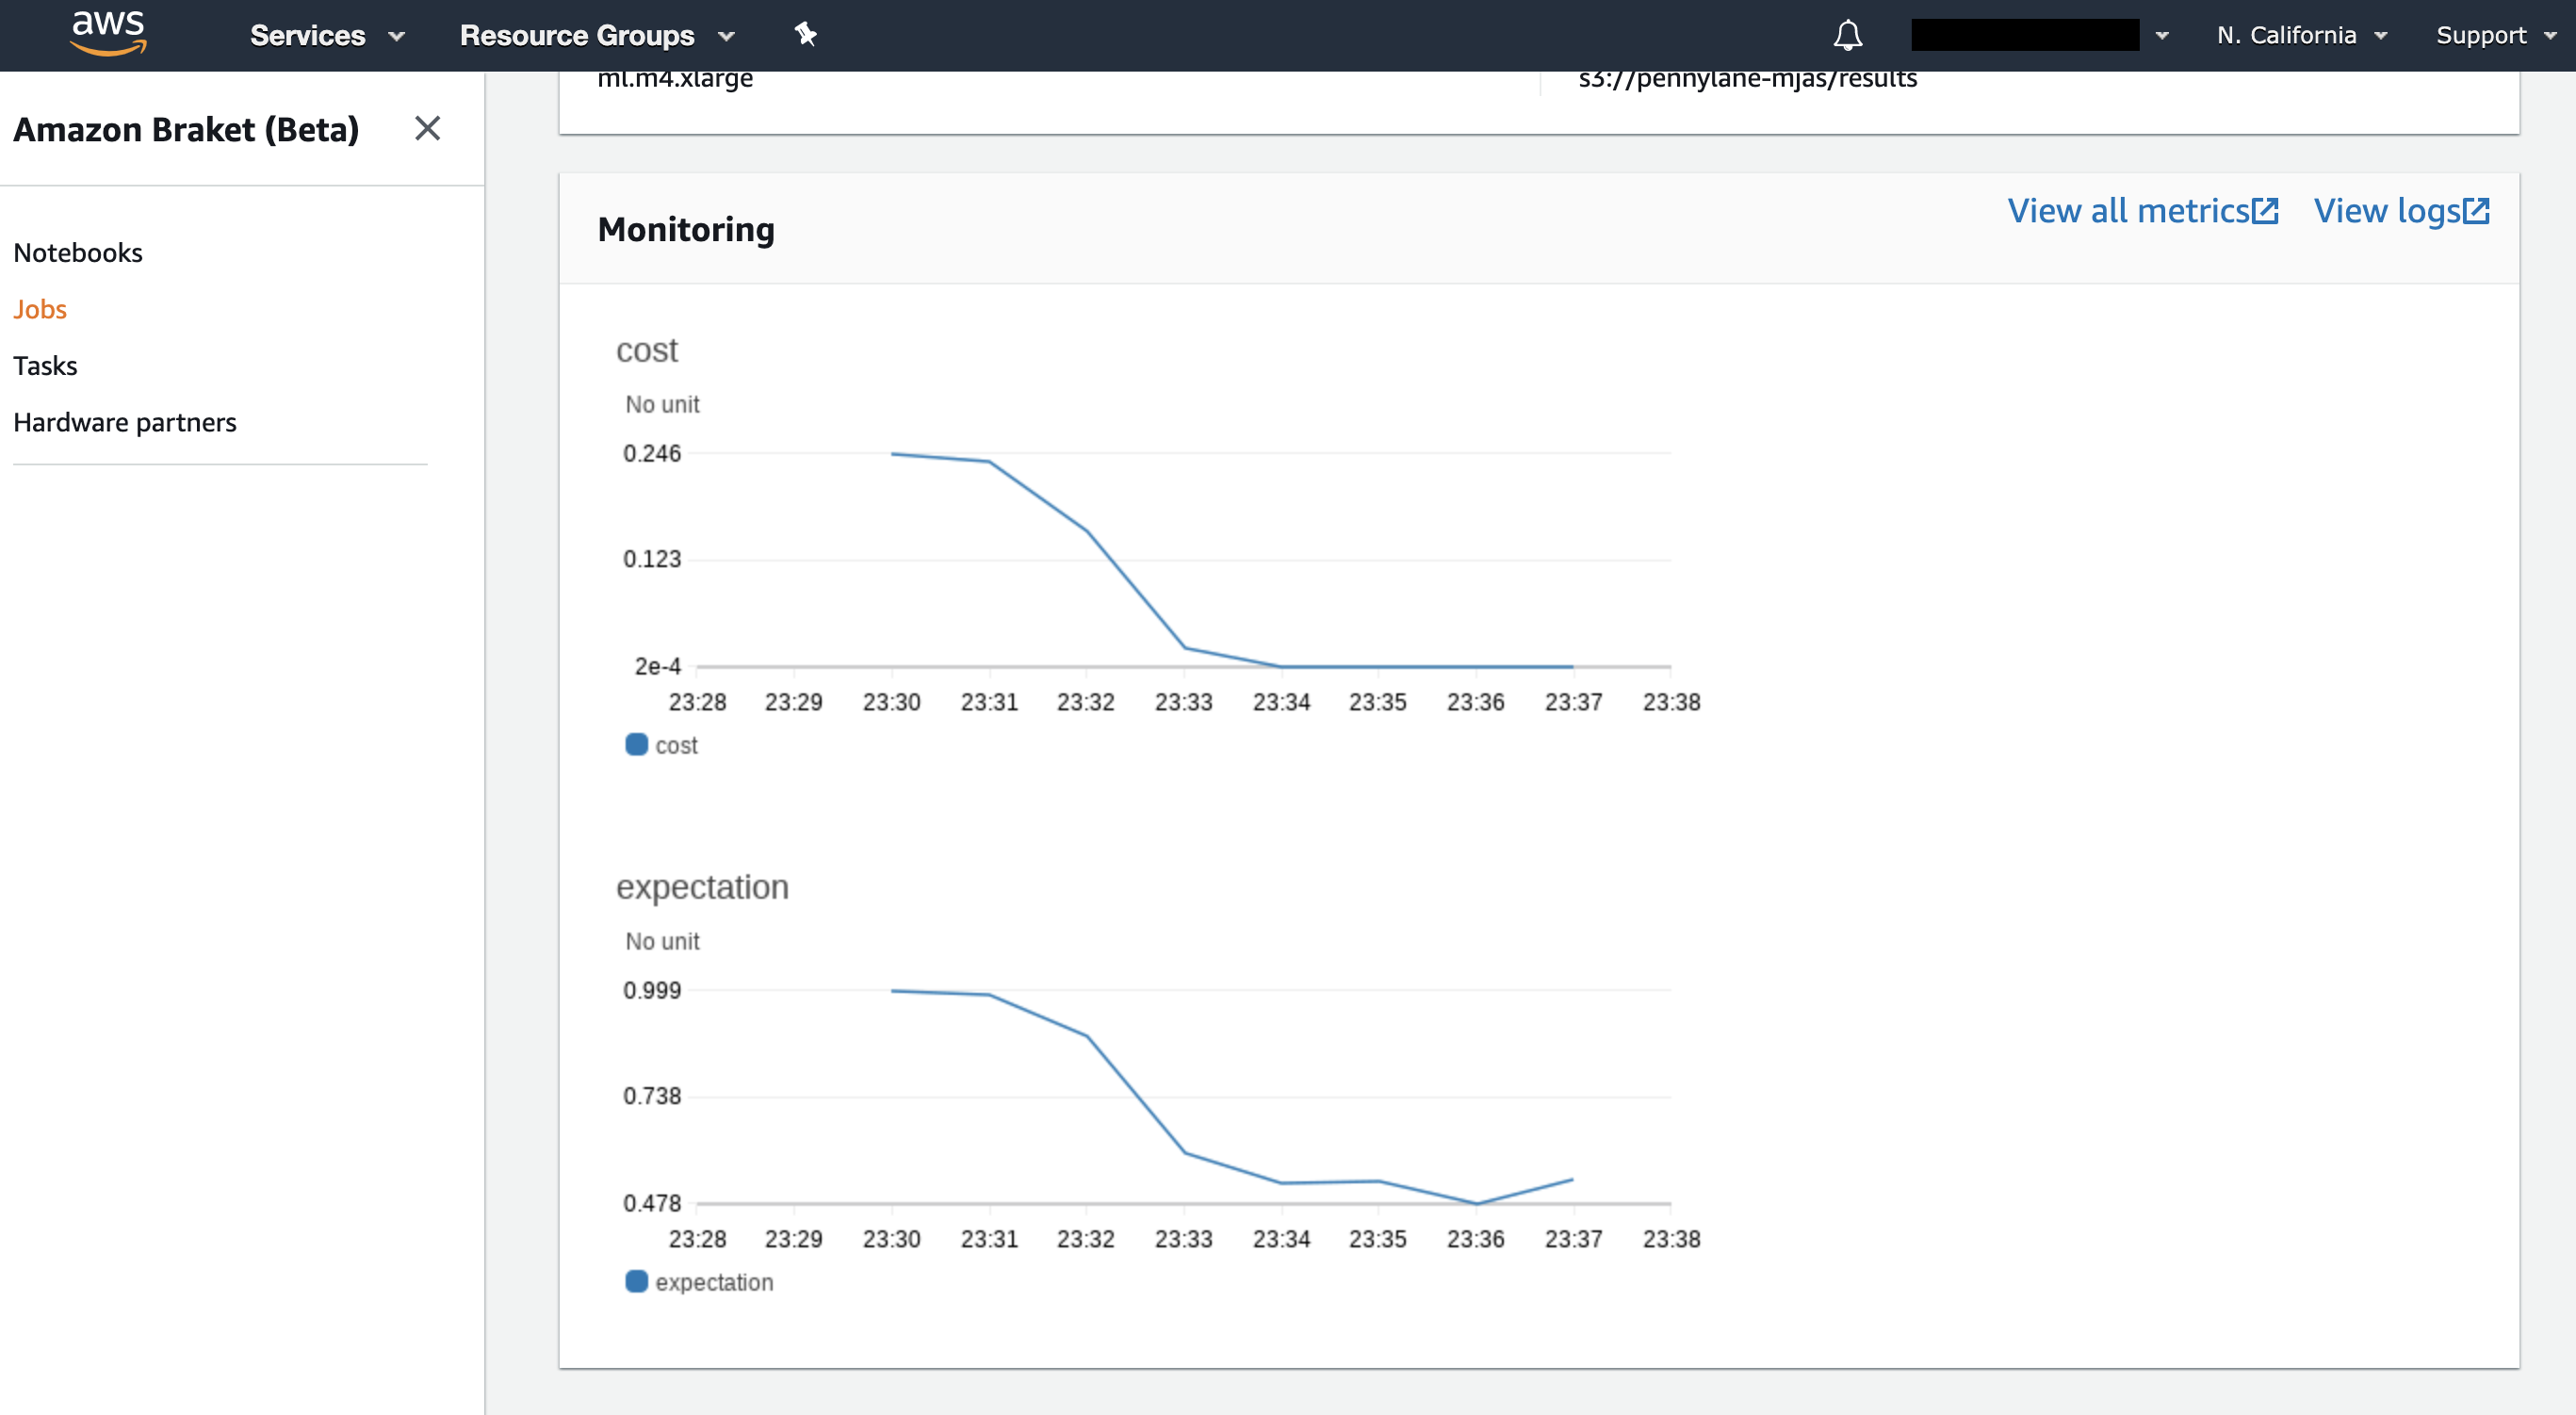

In [20]:
# CloudWatch custom metrics integrated into Braket console experience
Image(filename='figures/pl_Braket_console2.png', width=800, height=800)

### Visualize Results of Managed Job

Once the managed job is done, results are packed up and stored an S3.

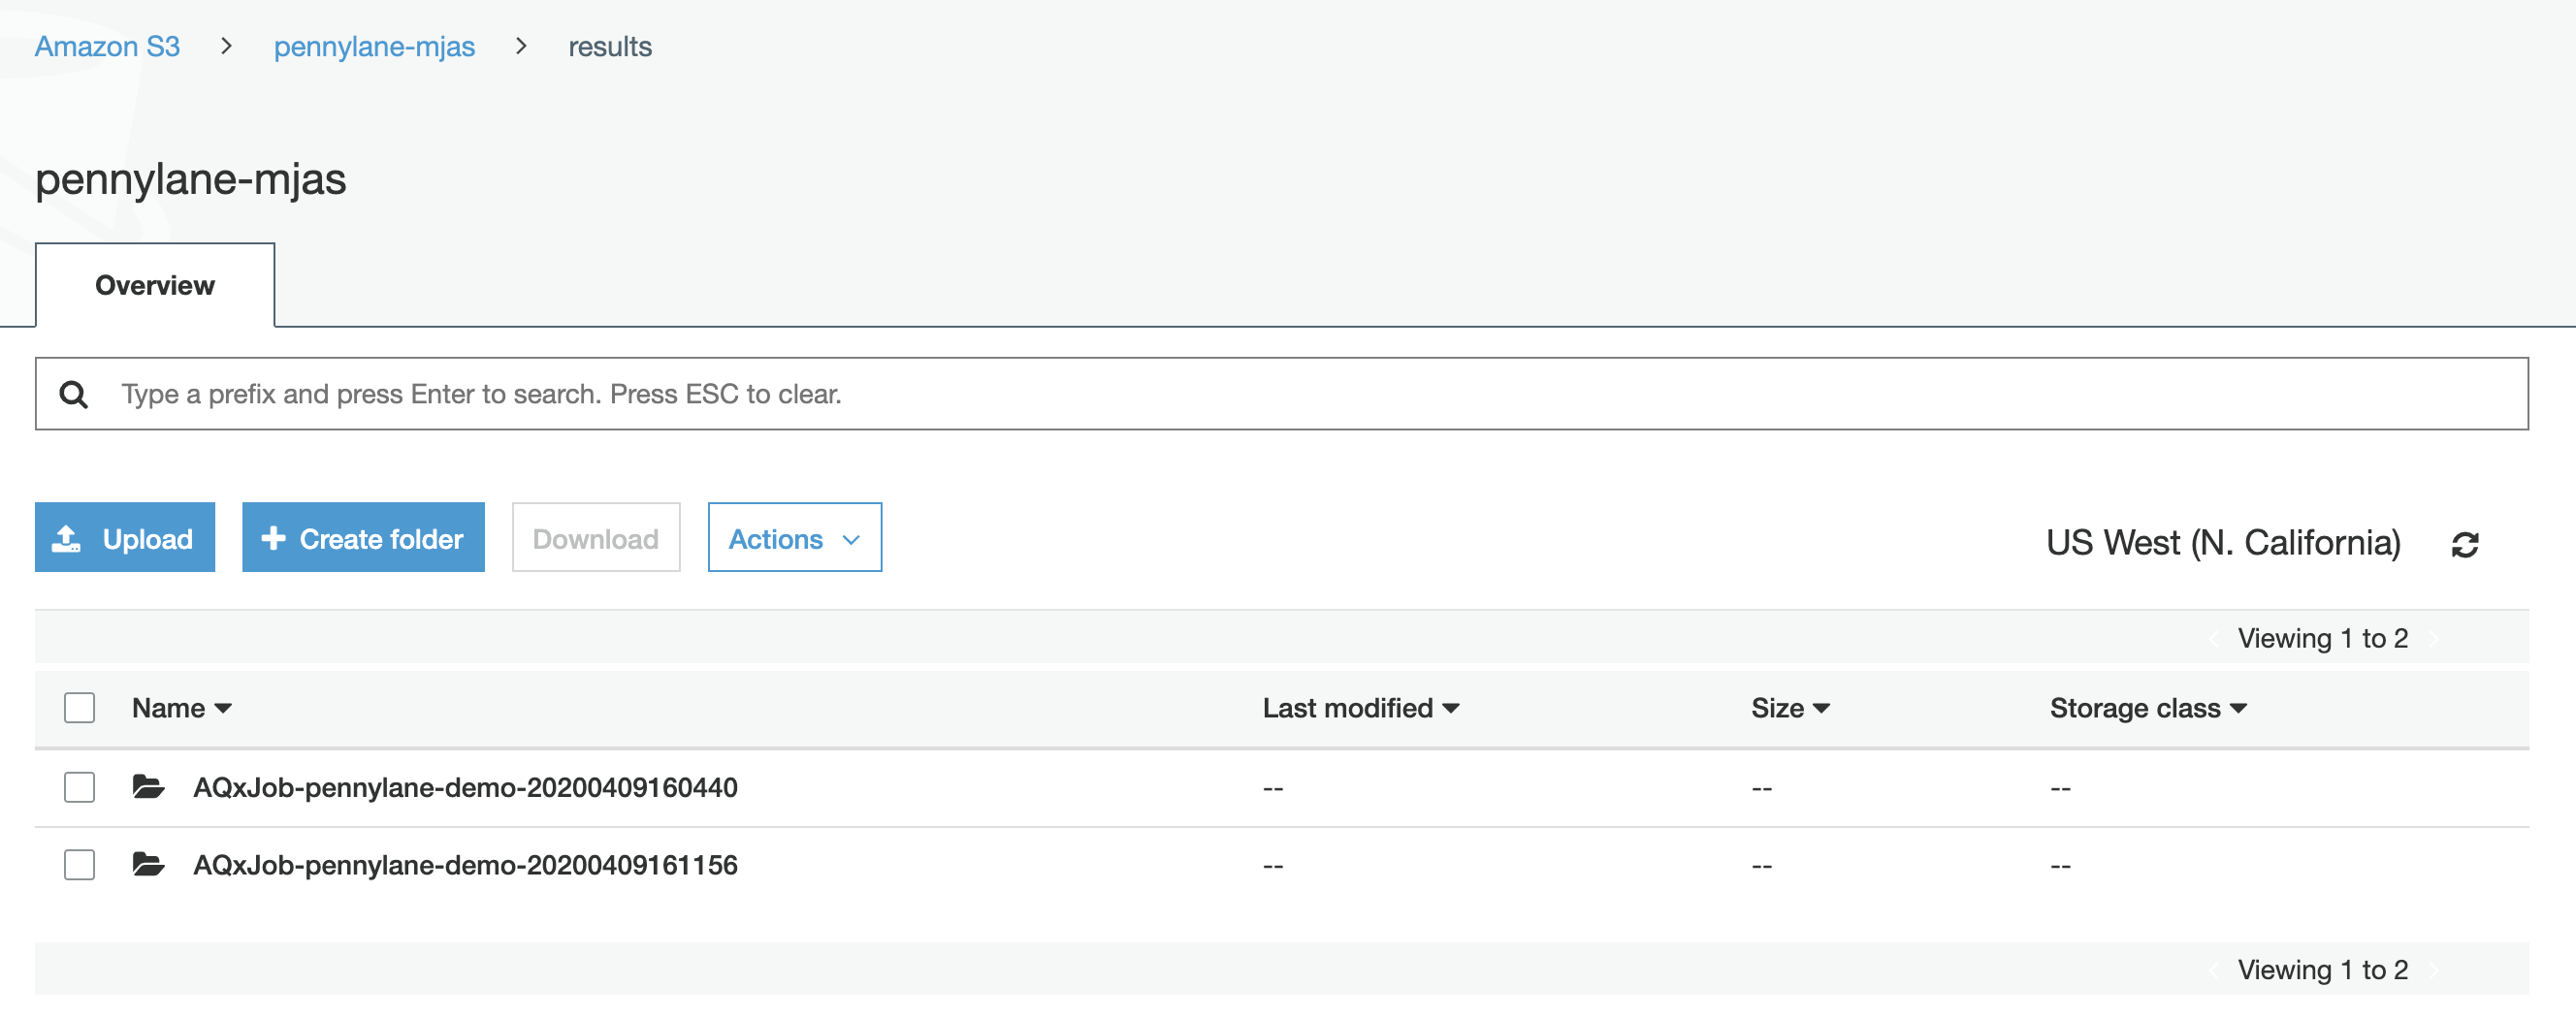

In [21]:
# screenshot from S3 location
Image(filename='figures/pl_results_s3.png', width=800, height=800)

__Step 4__: Retrieve results stored in S3 and analyze and visualize. 

In [22]:
# get the results from S3
# syntax: s3.download_file('BUCKET_NAME', 'OBJECT_NAME', 'FILE_NAME')
object_key = 'results/{}/output/model.tar.gz'.format('AQxJob-'+job_name)
tempfile = '/tmp/model.tar.gz' 
s3_client = session.client("s3")
s3_client.download_file(bucket, object_key, tempfile) 

In [23]:
# unzip the results
tar = tarfile.open(tempfile, "r:gz")
tar.extractall(path = '/tmp')

# load the results into the notebook
out = pickle.load(open('/tmp/out.pckl', "rb"))

expectation = out['expectation']
angles = out['angles']              
final_cost = out['final_cost']
cost_list = out['cost_list']

# clean-up temporary files
os.remove(tempfile) 

In [24]:
# print final results
print('Optimal angles:', angles)
print('Final cost:', final_cost)
print('Optimal expectation:', expectation)

Optimal angles: [0.164464 0.00396  1.08652 ]
Final cost: 0.00032400000000000056
Optimal expectation: 0.482


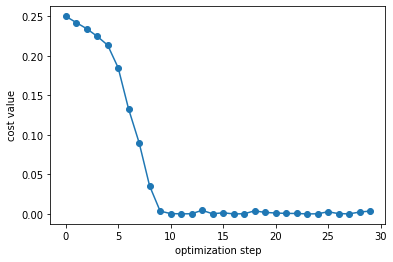

In [25]:
# plot optimization results
steps_list = np.arange(steps)

fig = plt.figure(1)
plt.plot(steps_list, cost_list, '-o', label='cost')
plt.xlabel('optimization step')
plt.ylabel('cost value')
plt.show()